In [1]:
import os
print(os.getcwd())
os.chdir('/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1')
print(os.getcwd())

/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1/tests
/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1


In [4]:
import pandas as pd

final_entities=pd.read_csv("export/multihop_rag/multihop_rag_final_entities.csv")
final_relationships=pd.read_csv("export/multihop_rag/multihop_rag_final_relationships_v1.csv")

In [5]:
# 设置pandas显示选项，增加最大列宽度
pd.set_option('display.max_colwidth', 200)  # 将200替换为你想要的长度
# 筛选 entity_name 长度小于30且 description 长度大于150 的行
filtered_df = final_entities[
    (final_entities['entity_name'].str.len() < 30) & 
    (final_entities['entity_name'].str.len() > 10) & 
    (final_entities['description'].str.len() > 50)
]

# 查看筛选后的数据框
filtered_df.head(10)


,entity_name,entity_type,description,id
3,Bolt Mobility,COMPANY,Bolt Mobility is introducing distance-based pricing,4
4,Crimson Tide,TEAM,Crimson Tide is the nickname of the Alabama football team,5
6,Lamar Jackson,PERSON,Lamar Jackson is a quarterback for the Baltimore Ravens.,7
8,Quarter - Final,CONCEPT,The quarter - final is the stage of a tournament where the four winning teams from the group stage compete to advance to the semi - final,9
15,audible audiobooks,PRODUCT,The Kindle Oasis supports audible audiobooks via bluetooth.,16
22,cranberries,PRODUCT,Marcus Urann introduced a way to put cranberries in a can in 1912. Cranberries are one of the few fruits native to the northern United States.,23
26,ezekiel elliott,PLAYER,Ezekiel Elliott is an American football running back for the Dallas Cowboys of the National Football League.,27
28,folklore and evermore albums,ALBUM,folklore and evermore albums are the tenth and eleventh studio albums by Taylor Swift.,29
31,gm meetings,EVENT,The GM meetings are an annual gathering of general managers from Major League Baseball teams.,32
36,hiv - positive,CONCEPT,hiv - positive refers to people who have been diagnosed with HIV.,37


In [6]:
# 设置pandas显示选项，增加最大列宽度
pd.set_option('display.max_colwidth', 200)  # 将200替换为你想要的长度
# 筛选 entity_name 长度小于30且 description 长度大于150 的行
filtered_df = final_relationships[
    (final_relationships['source_entity'].str.len() < 30) & 
    (final_relationships['source_entity'].str.len() > 5) & 
    (final_relationships['target_entity'].str.len() < 30) & 
    (final_relationships['target_entity'].str.len() > 5) & 
    (final_relationships['relationship_description'].str.len() > 50)
]

# 查看筛选后的数据框
filtered_df.head(10)


,source_entity,target_entity,relationship_type,relationship_description,source_id,target_id
12,Epoch Times,Falun Gong,Part-of,The Epoch Times is part of the Falun Gong organization.,3835,3963
16,bowser,flower kingdom,Located-in,bowser's mecha fortress is located in the flower kingdom,11848,14341
27,bowser,flower kingdom,Part-of,bowser's mecha fortress is part of the flower kingdom,11848,14341
50,Super Mario Bros. Wonder,Nintendo,Produced-by,Super Mario Bros. Wonder was developed by Nintendo.,8998,7038
52,Super Mario Bros. Wonder,Super Mario World,Compared-to,Super Mario Bros. Wonder is often compared to Super Mario World.,8998,9000
53,Berlin Wall,Gaza Strip,Located-in,The Berlin Wall was located in between the Gaza Strip and Israel.,2091,4285
54,Berlin Wall,Israel,Located-in,The Berlin Wall was located in between the Israel and the Gaza Strip.,2091,4990
55,Berlin Wall,Gaza Strip,Located-in,The Berlin Wall was located in between the Israel and the Gaza Strip.,2091,4285
56,Gaza Strip,Israel,Located-in,The Gaza Strip is located in between the Israel and the Berlin Wall.,4285,4990
58,barrier,israel,Located-in,"The sand clock had only proved itself in stopping illegal immigrants on the Israel-Egypt border, and the same fence that then-US president Donald Trump enthused over, and wanted to duplicate on th...",11494,15816


In [41]:
from src.extractors.embedding_extractor import generate_and_save_embeddings
from src.utils.config import OUTPUT_PATH

final_entities,final_relationships=generate_and_save_embeddings(final_entities,final_relationships,OUTPUT_PATH)
final_entities

In [42]:
# 找出不在 final_entities['id'] 列中的 source_id 和 target_id
invalid_source_ids = final_relationships[~final_relationships['source_id'].isin(final_entities['id'])]
invalid_target_ids = final_relationships[~final_relationships['target_id'].isin(final_entities['id'])]

# 打印不匹配的 source_id 和 target_id
print("Invalid source_ids (not in final_entities['id']):")
print(invalid_source_ids[['source_id']].drop_duplicates())

print("\nInvalid target_ids (not in final_entities['id']):")
print(invalid_target_ids[['target_id']].drop_duplicates())


Invalid source_ids (not in final_entities['id']):
       source_id
16738        947
16739      22038

Invalid target_ids (not in final_entities['id']):
       target_id
16738      12771


In [51]:
import igraph as ig
import networkx as nx

# Step 1: 确保 source_id 和 target_id 都在 final_entities['id'] 中
valid_ids = set(final_entities['id'])

# 过滤掉不合法的边（source_id 和 target_id 不存在于节点列表中的边）
valid_relationships = final_relationships[
    final_relationships['source_id'].isin(valid_ids) & final_relationships['target_id'].isin(valid_ids)
]

# Step 2: 创建节点的映射，确保节点ID连续
node_mapping = {node_id: idx for idx, node_id in enumerate(final_entities['id'])}

# 检查是否存在不合法的边
invalid_edges = valid_relationships[~valid_relationships['source_id'].isin(valid_ids) | 
                                    ~valid_relationships['target_id'].isin(valid_ids)]

# 打印不合法边
if not invalid_edges.empty:
    print("Invalid edges found:")
    print(invalid_edges)

# 重新映射 valid_relationships 中的 source_id 和 target_id 为连续的索引
valid_relationships['source_idx'] = valid_relationships['source_id'].map(node_mapping)
valid_relationships['target_idx'] = valid_relationships['target_id'].map(node_mapping)

# Step 3: 使用 igraph 创建无向图
ig_graph = ig.Graph(directed=False)
ig_graph.add_vertices(len(node_mapping))  # 添加节点（以数量为准）

# 添加映射后的边
ig_graph.add_edges(zip(valid_relationships['source_idx'], valid_relationships['target_idx']))

# Step 4: Leiden聚类
import leidenalg as la
partition = la.find_partition(ig_graph, la.ModularityVertexPartition)

# 输出聚类结果和模块度
clusters = partition.membership
modularity = partition.modularity
print(f"Modularity of the final clustering: {modularity}")

# 将聚类结果添加到 final_entities 中
final_entities['cluster'] = [clusters[node_mapping[node_id]] for node_id in final_entities['id']]


C:\Users\24917\AppData\Local\Temp\ipykernel_22972\3622548059.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_relationships['source_idx'] = valid_relationships['source_id'].map(node_mapping)
C:\Users\24917\AppData\Local\Temp\ipykernel_22972\3622548059.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_relationships['target_idx'] = valid_relationships['target_id'].map(node_mapping)


Modularity of the final clustering: 0.8789372424253074


In [62]:
from collections import Counter

# 统计每个聚类簇的节点数量
cluster_counts = Counter(partition.membership)

# 按照从多到少排序并输出前20个
top_20_clusters = cluster_counts.most_common(20)

# 打印前20个聚类及其节点数量
for cluster_id, count in top_20_clusters:
    print(f"Cluster {cluster_id} has {count} nodes")


Cluster 0 has 1260 nodes
Cluster 1 has 970 nodes
Cluster 2 has 857 nodes
Cluster 3 has 854 nodes
Cluster 4 has 446 nodes
Cluster 5 has 443 nodes
Cluster 6 has 371 nodes
Cluster 7 has 364 nodes
Cluster 8 has 353 nodes
Cluster 9 has 346 nodes
Cluster 10 has 328 nodes
Cluster 11 has 327 nodes
Cluster 12 has 321 nodes
Cluster 13 has 319 nodes
Cluster 14 has 277 nodes
Cluster 15 has 273 nodes
Cluster 16 has 255 nodes
Cluster 17 has 251 nodes
Cluster 18 has 244 nodes
Cluster 19 has 233 nodes


In [78]:
import networkx as nx

# Step 1: 创建 NetworkX 图 G
G = nx.Graph()

# Step 2: 添加节点（使用 final_entities 中的 id）
G.add_nodes_from(final_entities['id'])

# Step 3: 添加边（使用 valid_relationships 中的 source_id 和 target_id）
G.add_edges_from(zip(valid_relationships['source_id'], valid_relationships['target_id']))

# 打印一些图信息
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 23570
Number of edges: 23693


C:\Users\24917\AppData\Local\Temp\ipykernel_22972\560932590.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_edges = random.sample(G.edges(), sample_edge_size)


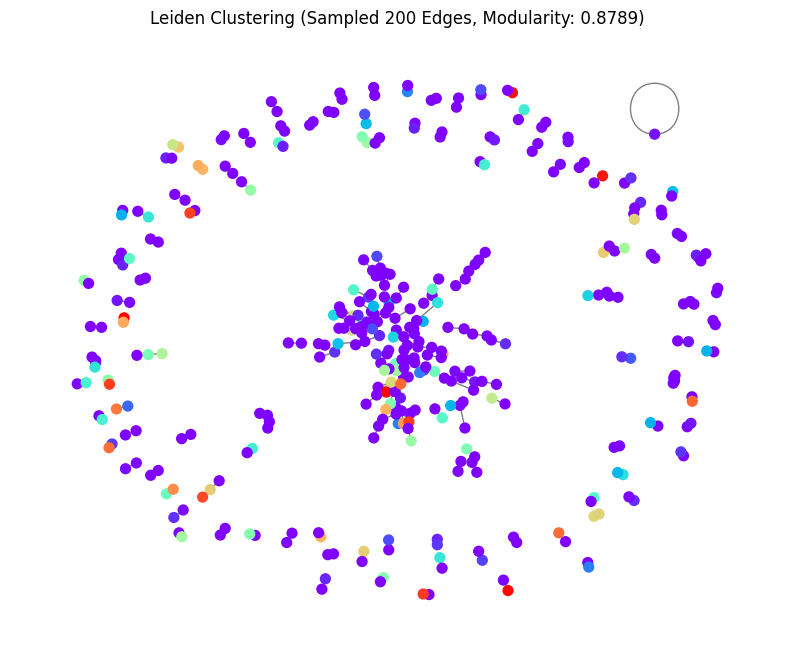

: 

In [83]:
import random
import matplotlib.pyplot as plt
import networkx as nx

# 设定采样的边数量
sample_edge_size = 200

# 随机选择一定数量的边进行采样
sampled_edges = random.sample(G.edges(), sample_edge_size)

# 从采样的边中提取节点
sampled_nodes = set([node for edge in sampled_edges for node in edge])

# 生成采样节点的子图
subgraph = G.subgraph(sampled_nodes)

# 为采样的节点和边生成布局
pos = nx.spring_layout(subgraph)

plt.figure(figsize=(10, 8))

# 为采样的节点着色
sampled_clusters = [clusters[node] for node in sampled_nodes]
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color=sampled_clusters, cmap=plt.cm.rainbow)

# 绘制采样的边
nx.draw_networkx_edges(subgraph, pos, edgelist=sampled_edges, alpha=0.5)

plt.title(f"Leiden Clustering (Sampled {sample_edge_size} Edges, Modularity: {modularity:.4f})")
plt.axis('off')
plt.show()


In [45]:
valid_relationships

,source_entity,target_entity,relationship_type,relationship_description,source_id,target_id
0,Li,Falun Gong,Affiliated-with,Li is affiliated with Falun Gong.,5841,3963
1,Epoch Times,Li,Worked-for,Epoch Times worked for Li.,3835,5841
2,The Epoch Times,Location,Located-in,The Epoch Times is located in multiple countries.,9282,5932
3,Microsoft,The Epoch Times,Affiliated-with,Microsoft is affiliated with The Epoch Times.,6510,9282
4,California,The Epoch Times,Located-in,California is located in The Epoch Times.,2502,9282
...,...,...,...,...,...,...
26033,Lille,Alphonso Davies,Part-of,Lille is a part of Davies,5873,1515
26034,Canada Soccer,"November 18, 2023",Happened-at,"November 18, 2023 is an event that happened at Canada Soccer",2535,7125
26035,David,Lille,Part-of,David is a part of Lille,3263,5873
26036,David,Milan Borjan,Part-of,David is a part of Borjan,3263,6561
